In [1]:
import torch

# always set dtype before creating any tensors
dtype = torch.float32                # MPS supports only float32 and float16
torch.set_default_dtype(dtype)

# detect MPS first
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("MPS available:", torch.backends.mps.is_available())

# now this works fine
x = torch.ones((3, 3), device=device, dtype=dtype)
print(x.device, x.dtype)

MPS available: True
mps:0 torch.float32


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# -------------------------
# Physical constants
# -------------------------
# Geometry
L = 1.0    # a = 1 cm 
W = 0.5    # b = 0.5 cm

# Material scale and parameters
coff_mat = 1e9
lambda_  = 5.64   * coff_mat
mu_T     = 2.46   * coff_mat
alpha    = 1.27   * coff_mat 
mu_L     = 5.66   * coff_mat
beta     = 227.29 * coff_mat

# Thickness and angle
h = 1.0
theta_deg = 30
theta_rad = np.deg2rad(theta_deg)

# Loading / forcing
percentage   = -0.05       # right edge prescribed u = percentage * L
w            = 5.0         # fiber waviness parameter
coeff_force  = 1e-1
f_x          = -10.0 * coeff_force
f_y          = 0.0

# Stress scaling
sf = 1e9


In [3]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

In [4]:
use_wavy_fiber = False

In [5]:
def a_components(x):
    """
    Return a1(x), a2(x) as tensors on the correct device.
    If use_wavy_fiber=False -> constant (cosθ, sinθ).
    If True -> wavy direction from your Fiber Direction note.
    """
    if not use_wavy_fiber:
        a1 = torch.full_like(x, float(np.cos(theta_rad)))
        a2 = torch.full_like(x, float(np.sin(theta_rad)))
        return a1, a2
    # wavy fiber: normalized [1, w*cos(w*x/L)]
    arg = w * x / L
    denom = torch.sqrt(1.0 + (w**2) * torch.cos(arg)**2)
    a1 = 1.0 / denom
    a2 = (w * torch.cos(arg)) / denom
    return a1, a2

In [6]:
def stress_tensor(Exx, Eyy, Exy, x):
    a1, a2 = a_components(x)   
    trE = Exx + Eyy
    Ea_x = Exx * a1 + Exy * a2
    Ea_y = Exy * a1 + Eyy * a2
    aEa  = Exx*(a1*a1) + 2.0*Exy*(a1*a2) + Eyy*(a2*a2)

    t1_xx = trE * (lambda_ + alpha*(a1*a1))
    t1_xy = trE * (alpha * a1 * a2)
    t1_yy = trE * (lambda_ + alpha*(a2*a2))

    t2_xx = 2.0 * mu_T * Exx
    t2_xy = 2.0 * mu_T * Exy
    t2_yy = 2.0 * mu_T * Eyy

    t3_xx = aEa * (alpha + beta*(a1*a1))
    t3_xy = aEa * (beta * a1 * a2)
    t3_yy = aEa * (alpha + beta*(a2*a2))

    K = 2.0 * (mu_L - mu_T)
    t4_xx = K * (2.0 * a1 * Ea_x)
    t4_xy = K * (a1 * Ea_y + Ea_x * a2)
    t4_yy = K * (2.0 * a2 * Ea_y)

    sig_xx = t1_xx + t2_xx + t3_xx + t4_xx
    sig_xy = t1_xy + t2_xy + t3_xy + t4_xy
    sig_yy = t1_yy + t2_yy + t3_yy + t4_yy
    return (h/sf)*sig_xx, (h/sf)*sig_yy, (h/sf)*sig_xy

In [7]:
def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    Exx = u_x_true; Eyy = v_y_true; Exy = 0.5*(u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

In [8]:
Fx_scale = h / sf
Fy_scale = h / sf

In [9]:
def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:, i:i+1] for i in range(6))

    # true (autograd) strains
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]

    # keep your network's extra outputs close to the autograd strains
    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    # physics uses autograd strains
    Exx, Eyy = u_x_true, v_y_true
    Exy = 0.5 * (u_y_true + v_x_true)
    Sxx, Syy, Sxy = stress_tensor(Exx, Eyy, Exy, x=x)

    # div S + f = 0 (scaled)
    Sxx_x = torch.autograd.grad(Sxx, x, torch.ones_like(Sxx), retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, torch.ones_like(Syy), retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y + Fx_scale * f_x
    ry = Syy_y + Sxy_x + Fy_scale * f_y
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad


In [10]:
def boundary_condition_loss(model, L, W):
    # Left edge A: clamp 
    loss_pen = 10**(-9)
    penatly = 10**(5)
    
    y_A = torch.linspace(-W/2, W/2, 500, device=device, dtype=dtype).reshape(-1,1)
    x_A = (-L/2) * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean((u_A - loss_pen)**2 + penatly * (v_A - loss_pen)**2)

    # Right edge D: displacement BC
    x_D = (L/2) * torch.ones_like(y_A)
    out_D = model(x_D, y_A)
    u_D, v_D = out_D[:,0:1], out_D[:,1:2]
    loss_D = torch.mean((u_D - percentage*L)**2 + penatly * (v_D - loss_pen)**2)

    # Bottom edge C: traction-free 
    x_C = torch.linspace(-L/2, L/2, 200, device=device, dtype=dtype).reshape(-1,1).requires_grad_(True)
    y_C = (-W/2) * torch.ones_like(x_C).requires_grad_(True)

    out_C = model(x_C, y_C)
    uC, vC = out_C[:,0:1], out_C[:,1:2]
    uCx = torch.autograd.grad(uC, x_C, torch.ones_like(uC), retain_graph=True, create_graph=True)[0]
    uCy = torch.autograd.grad(uC, y_C, torch.ones_like(uC), retain_graph=True, create_graph=True)[0]
    vCx = torch.autograd.grad(vC, x_C, torch.ones_like(vC), retain_graph=True, create_graph=True)[0]
    vCy = torch.autograd.grad(vC, y_C, torch.ones_like(vC), retain_graph=True, create_graph=True)[0]
    Exx_C, Eyy_C = uCx, vCy
    Exy_C = 0.5*(uCy + vCx)
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C, x=x_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    # Top edge B: traction-free 
    y_B = (W/2) * torch.ones_like(x_C).requires_grad_(True)

    out_B = model(x_C, y_B)
    uB, vB = out_B[:,0:1], out_B[:,1:2]
    uBx = torch.autograd.grad(uB, x_C, torch.ones_like(uB), retain_graph=True, create_graph=True)[0]
    uBy = torch.autograd.grad(uB, y_B, torch.ones_like(uB), retain_graph=True, create_graph=True)[0]
    vBx = torch.autograd.grad(vB, x_C, torch.ones_like(vB), retain_graph=True, create_graph=True)[0]
    vBy = torch.autograd.grad(vB, y_B, torch.ones_like(vB), retain_graph=True, create_graph=True)[0]
    Exx_B, Eyy_B = uBx, vBy
    Exy_B = 0.5*(uBy + vBx)
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B, x=x_C)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

In [11]:
def train_adam_with_scheduler(model, n_epochs, n_points, L, W, lr=1e-3, eta_min=1e-5):
    """Adam with cosine LR; returns loss history."""
    w_pde, w_bc = 1.0, 50.0
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs, eta_min=eta_min)
    history = []
    for ep in range(n_epochs):
        x = torch.rand(n_points,1, device=device, dtype=dtype)*L - L/2
        y = torch.rand(n_points,1, device=device, dtype=dtype)*W - W/2
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        history.append(loss.item())
        if ep % 500 == 0:
            print(f"[Adam]  Epoch {ep:5d} | lr={sched.get_last_lr()[0]:.2e} | "
                  f"Total:{loss.item():.3e} | PDE:{lp.item():.3e} | BC:{lb.item():.3e}")
    return history

def train_lbfgs_finetune(model, n_epochs, n_points, L, W, lr=1.0):
    """
    Lightweight LBFGS fine-tune: run n_epochs single-step LBFGS iterations 
    """
    w_pde, w_bc = 1.0, 50.0
    history = []
    for ep in range(n_epochs):
        opt = torch.optim.LBFGS(
            model.parameters(), lr=lr, max_iter=1,
            line_search_fn="strong_wolfe", history_size=100,
            tolerance_grad=1e-10, tolerance_change=1e-12
        )
        def closure():
            opt.zero_grad()
            x = torch.rand(n_points,1, device=device, dtype=dtype)*L - L/2
            y = torch.rand(n_points,1, device=device, dtype=dtype)*W - W/2
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model, L, W)
            loss = w_pde*lp + w_bc*lb
            loss.backward()
            return loss
        loss = opt.step(closure)
        history.append(loss.item())
        if ep % 200 == 0:
            print(f"[LBFGS] Epoch {ep:5d} | loss={loss.item():.3e}")
    return history

In [12]:
model = PINN().to(device)

ADAM_EPOCHS  = 10000
LBFGS_EPOCHS = 2000
n_points = 1000

adam_hist  = train_adam_with_scheduler(model, ADAM_EPOCHS,  n_points, L, W, lr=1e-3, eta_min=1e-5)
lbfgs_hist = train_lbfgs_finetune(model, LBFGS_EPOCHS, n_points, L, W, lr=1.0)

loss_history = adam_hist + lbfgs_hist  # combined

torch.save(model.state_dict(), "pinn_fiber_elasticity_new.pth")
print("✅ Model weights saved to pinn_fiber_elasticity_new.pth")

[Adam]  Epoch     0 | lr=1.00e-03 | Total:4.401e+04 | PDE:7.973e+01 | BC:8.787e+02
[Adam]  Epoch   500 | lr=9.94e-04 | Total:1.426e-01 | PDE:6.450e-02 | BC:1.562e-03
[Adam]  Epoch  1000 | lr=9.76e-04 | Total:1.006e-01 | PDE:3.046e-02 | BC:1.403e-03
[Adam]  Epoch  1500 | lr=9.46e-04 | Total:8.610e-02 | PDE:1.893e-02 | BC:1.343e-03
[Adam]  Epoch  2000 | lr=9.05e-04 | Total:7.837e-02 | PDE:1.309e-02 | BC:1.306e-03
[Adam]  Epoch  2500 | lr=8.55e-04 | Total:7.348e-02 | PDE:9.497e-03 | BC:1.280e-03
[Adam]  Epoch  3000 | lr=7.96e-04 | Total:6.994e-02 | PDE:7.007e-03 | BC:1.259e-03
[Adam]  Epoch  3500 | lr=7.30e-04 | Total:6.718e-02 | PDE:5.197e-03 | BC:1.240e-03
[Adam]  Epoch  4000 | lr=6.58e-04 | Total:6.526e-02 | PDE:4.240e-03 | BC:1.220e-03
[Adam]  Epoch  4500 | lr=5.82e-04 | Total:6.327e-02 | PDE:3.172e-03 | BC:1.202e-03
[Adam]  Epoch  5000 | lr=5.05e-04 | Total:2.171e-01 | PDE:3.001e-03 | BC:4.283e-03
[Adam]  Epoch  5500 | lr=4.27e-04 | Total:9.545e-02 | PDE:2.501e-03 | BC:1.859e-03
[Ada

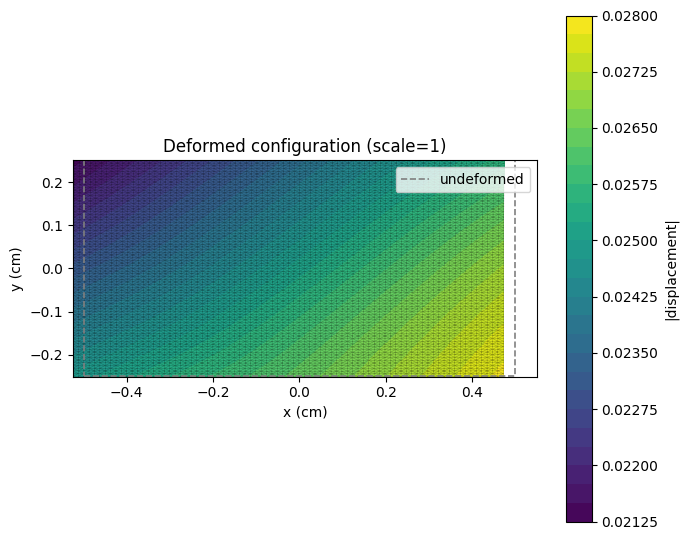

In [13]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

@torch.no_grad()
def plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0, cmap="viridis"):
    model.eval()
    device = next(model.parameters()).device

    # Build a uniform grid over the plate
    xs = torch.linspace(-L/2, L/2, n_per_side, device=device)
    ys = torch.linspace(-W/2, W/2, n_per_side, device=device)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    x = Xg.reshape(-1, 1)
    y = Yg.reshape(-1, 1)

    # Predict [u, v] with the PINN
    out = model(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Deformed coordinates (amplified by 'scale' for visibility)
    x_def = (x + scale * u).detach().cpu().numpy().ravel()
    y_def = (y + scale * v).detach().cpu().numpy().ravel()

    # Undeformed for reference
    x_und = x.detach().cpu().numpy().ravel()
    y_und = y.detach().cpu().numpy().ravel()

    # Triangulate the (regular) grid for a nicer surface plot
    tri = mtri.Triangulation(x_und, y_und)

    # Displacement magnitude for coloring
    disp_mag = torch.sqrt(u**2 + v**2).detach().cpu().numpy().ravel()

    # Plot
    plt.figure(figsize=(7, 5.5))
    tpc = plt.tricontourf(x_def, y_def, tri.triangles, disp_mag, levels=30, cmap=cmap)
    plt.colorbar(tpc, label="|displacement|")
    # draw deformed mesh lines
    plt.triplot(x_def, y_def, tri.triangles, lw=0.3, color="k", alpha=0.35)

    # outline of undeformed boundary for reference
    plt.plot([ -L/2,  L/2,  L/2, -L/2, -L/2 ],
             [ -W/2, -W/2,  W/2,  W/2, -W/2 ], ls="--", lw=1.2, color="gray", label="undeformed")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (cm)"); plt.ylabel("y (cm)")
    plt.title(f"Deformed configuration (scale={scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0)

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math


L, W = 1.0, 0.5  # geometry (cm)

# ---------- Load COMSOL CSV ----------
def load_comsol_csv(path):
    header_fields = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("% X,"):
                header_fields = line.strip()[2:].split(",")
                break
    if header_fields is None:
        raise RuntimeError("Could not find '% X,' header in COMSOL CSV.")
    df = pd.read_csv(path, comment="%", header=None, names=header_fields, engine="python")
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(how="all").reset_index(drop=True)

# ---------- Define PINN ----------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

# ---------- Compute error metrics ----------
def compute_errors(model, df):
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    x = torch.tensor(df["x (cm)"].values, dtype=torch.float32).reshape(-1,1).to(device)
    y = torch.tensor(df["y (cm)"].values, dtype=torch.float32).reshape(-1,1).to(device)

    with torch.no_grad():
        out = model(x, y)
    u_pred = out[:,0].cpu().numpy()
    v_pred = out[:,1].cpu().numpy()

    u_true = df["u1 (cm)"].values
    v_true = df["u2 (cm)"].values

    # total MSE (u + v combined)
    total_mse = np.mean((u_pred - u_true)**2 + (v_pred - v_true)**2)

    # relative L2 errors
    rel_L2_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
    rel_L2_v = np.linalg.norm(v_pred - v_true) / np.linalg.norm(v_true)

    return total_mse, rel_L2_u, rel_L2_v

# ---------- Main comparison ----------
if __name__ == "__main__":
    # Paths to data
    csv_tension = '/Users/murat/Downloads/For Murat/Percentage 0.025.csv'       # COMSOL tension file
    csv_compression = '/Users/murat/Downloads/For Murat/Percentage -0.05.csv'    # COMSOL compression file
    pth_tension = "pinn_fiber_elasticity_new.pth"
    pth_compression = '/Users/murat/Desktop/Nerural_Network_Constitutive_Equations/pinn_fiber_elasticity_new.pth'

    # Load data
    df_tension = load_comsol_csv(csv_tension)
    df_compression = load_comsol_csv(csv_compression)

    # Initialize models
    model_tension = PINN()
    model_compression = PINN()
    model_tension.load_state_dict(torch.load(pth_tension, map_location="cpu"))
    model_compression.load_state_dict(torch.load(pth_compression, map_location="cpu"))

    # Compute metrics
    mse_ten, L2u_ten, L2v_ten = compute_errors(model_tension, df_tension)
    mse_comp, L2u_comp, L2v_comp = compute_errors(model_compression, df_compression)
    print("\n Compression case:")
    print(f"   Total MSE:        {mse_comp:.6e}")
    print(f"   Rel. L2 (u_x):    {L2u_comp:.6e}")
    print(f"   Rel. L2 (u_y):    {L2v_comp:.6e}") 


 Compression case:
   Total MSE:        2.797562e-04
   Rel. L2 (u_x):    5.189330e-01
   Rel. L2 (u_y):    9.766954e-01


/var/folders/pt/b943j30n03g51nn4mmps3krc0000gp/T/ipykernel_33642/3815012280.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_tension.load_state_dict(torch.load(pth